# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
x = np.array([[1,6,4.,4],[9,2,5,1],[5,3,7,1]])
x

array([[ 1.,  6.,  4.,  4.],
       [ 9.,  2.,  5.,  1.],
       [ 5.,  3.,  7.,  1.]])

In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.358218
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *10 classes. each get equal score => each prob = 0.1. loss = -log(0.1)*


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.021891 analytic: -2.021891, relative error: 5.025764e-08
numerical: 2.721189 analytic: 2.721189, relative error: 1.572694e-09
numerical: 1.244415 analytic: 1.244415, relative error: 1.616982e-08
numerical: -0.598313 analytic: -0.598313, relative error: 9.940136e-08
numerical: 2.218907 analytic: 2.218907, relative error: 2.474654e-08
numerical: 1.059774 analytic: 1.059774, relative error: 2.269119e-08
numerical: 0.415170 analytic: 0.415170, relative error: 1.681786e-07
numerical: 3.120548 analytic: 3.120548, relative error: 1.567836e-08
numerical: -2.259938 analytic: -2.259938, relative error: 3.750657e-08
numerical: -1.929748 analytic: -1.929748, relative error: 8.375774e-09
numerical: 2.862065 analytic: 2.862065, relative error: 2.032612e-08
numerical: 1.761732 analytic: 1.761732, relative error: 4.081777e-08
numerical: 5.252553 analytic: 5.252553, relative error: 9.595298e-09
numerical: -1.233345 analytic: -1.233345, relative error: 3.165550e-09
numerical: 1.612427 anal

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.358218e+00 computed in 0.062396s
vectorized loss: 2.358218e+00 computed in 0.004571s
Loss difference: 0.000000
Gradient difference: 0.000000


In [8]:
from cs231n.classifiers import softmax_predict
from cs231n.classifiers import Softmax
sm = Softmax()
loss_hist = sm.train(X_dev, y_dev, learning_rate=1e-7, reg=5e4, num_iters=1500, verbose=True)
acc_tr = np.mean(sm.predict(X_dev) == y_dev)
print acc_tr

iteration 0 / 1500: loss 758.595223
iteration 100 / 1500: loss 278.216053
iteration 200 / 1500: loss 103.003833
iteration 300 / 1500: loss 38.974754
iteration 400 / 1500: loss 15.563683
iteration 500 / 1500: loss 6.942361
iteration 600 / 1500: loss 3.814160
iteration 700 / 1500: loss 2.614620
iteration 800 / 1500: loss 2.221348
iteration 900 / 1500: loss 2.091115
iteration 1000 / 1500: loss 1.997050
iteration 1100 / 1500: loss 2.004721
iteration 1200 / 1500: loss 1.982368
iteration 1300 / 1500: loss 1.983098
iteration 1400 / 1500: loss 2.007060
0.458


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = np.logspace(np.log10(1e-7), np.log10(5e-5), num=5) #[1e-7, 5e-7]
regularization_strengths = np.logspace(np.log10(5e4), np.log10(1e8), num=5) #[5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        sm = Softmax()
        sm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        acc_tr = np.mean(sm.predict(X_train) == y_train)
        acc_va = np.mean(sm.predict(X_val) == y_val)
        print (lr, reg), (acc_tr, acc_va)
        results[(lr, reg)] = (acc_tr, acc_va)
        if acc_va > best_val:
            best_val = acc_va
            best_softmax = sm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

(9.9999999999999995e-08, 49999.999999999993) (0.32926530612244898, 0.34200000000000003)
(9.9999999999999995e-08, 334370.152488211) (0.2755918367346939, 0.28199999999999997)
(9.9999999999999995e-08, 2236067.9774997896) (0.23538775510204082, 0.246)
(9.9999999999999995e-08, 14953487.812212205) (0.23187755102040816, 0.23300000000000001)


cs231n/classifiers/softmax.py:79: RuntimeWarning: overflow encountered in exp
  es = np.exp(X.dot(W)) # exp(scores) (N,C)
cs231n/classifiers/softmax.py:80: RuntimeWarning: invalid value encountered in divide
  es /= np.sum(es, axis=1)[:, np.newaxis] # es = probilities now
cs231n/classifiers/softmax.py:81: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(es[each_row, y]))


(9.9999999999999995e-08, 100000000.0) (0.10026530612244898, 0.086999999999999994)
(4.728708045015879e-07, 49999.999999999993) (0.31816326530612243, 0.34100000000000003)
(4.728708045015879e-07, 334370.152488211) (0.25697959183673469, 0.27500000000000002)
(4.728708045015879e-07, 2236067.9774997896) (0.2076326530612245, 0.20100000000000001)
(4.728708045015879e-07, 14953487.812212205) (0.10026530612244898, 0.086999999999999994)
(4.728708045015879e-07, 100000000.0) (0.10026530612244898, 0.086999999999999994)
(2.2360679774997895e-06, 49999.999999999993) (0.30091836734693878, 0.29499999999999998)
(2.2360679774997895e-06, 334370.152488211) (0.22906122448979591, 0.25800000000000001)
(2.2360679774997895e-06, 2236067.9774997896) (0.10026530612244898, 0.086999999999999994)
(2.2360679774997895e-06, 14953487.812212205) (0.10026530612244898, 0.086999999999999994)
(2.2360679774997895e-06, 100000000.0) (0.10026530612244898, 0.086999999999999994)
(1.0573712634405641e-05, 49999.999999999993) (0.126571428

In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.335000


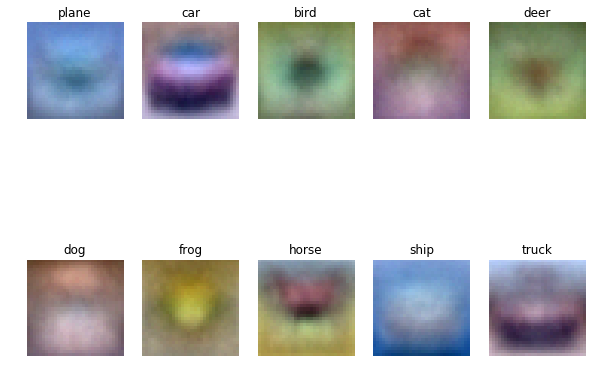

In [11]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])